<a href="https://colab.research.google.com/github/Redcoder815/Deep_Learning_PyTorch/blob/main/03SoftMaxRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [3]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [4]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1771, 0.1954, 0.2810, 0.1455, 0.2010],
         [0.1964, 0.1480, 0.2451, 0.2584, 0.1521]]),
 tensor([1., 1.]))

In [5]:
class SoftmaxRegressionScratch():
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W) + self.b)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)

In [6]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [7]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [8]:
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)

Using nn.Parameter

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

In [13]:
class SoftmaxRegressionScratch(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.W = nn.Parameter(torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True))
        self.b = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return F.softmax(torch.matmul(X, self.W) + self.b, dim=1)

    def loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)

In [14]:
# Hyperparameters
batch_size = 256
lr = 0.1
max_epochs = 5

# Data loading
transformer = transforms.ToTensor()
mnist_train = datasets.FashionMNIST(root="../data", train=True, transform=transformer, download=True)
mnist_val = datasets.FashionMNIST(root="../data", train=False, transform=transformer, download=True)

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
val_iter = data.DataLoader(mnist_val, batch_size, shuffle=False, num_workers=4)

# Model initialization
num_inputs = 784
num_outputs = 10
model = SoftmaxRegressionScratch(num_inputs, num_outputs)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training loop
for epoch in range(max_epochs):
    model.train()
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = model(X)
        l = model.loss(y_hat, y)
        optimizer.zero_grad()
        l.sum().backward()
        optimizer.step()
        train_l_sum += l.sum().item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.numel()

    # Validation
    model.eval()
    val_acc_sum, val_n = 0.0, 0
    with torch.no_grad():
        for X, y in val_iter:
            y_hat = model(X)
            val_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            val_n += y.numel()
    val_accuracy = val_acc_sum / val_n
    print(f'Epoch {epoch + 1}, Loss: {train_l_sum / n:.4f}, Train Accuracy: {train_acc_sum / n:.4f}, Validation Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Loss: 0.0077, Train Accuracy: 0.5891, Validation Accuracy: 0.6695
Epoch 2, Loss: 0.0071, Train Accuracy: 0.6826, Validation Accuracy: 0.6804
Epoch 3, Loss: 0.0070, Train Accuracy: 0.7163, Validation Accuracy: 0.7327
Epoch 4, Loss: 0.0069, Train Accuracy: 0.7528, Validation Accuracy: 0.7494
Epoch 5, Loss: 0.0068, Train Accuracy: 0.7632, Validation Accuracy: 0.7580


In [15]:
X, y = next(iter(val_iter))
with torch.no_grad():
    preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

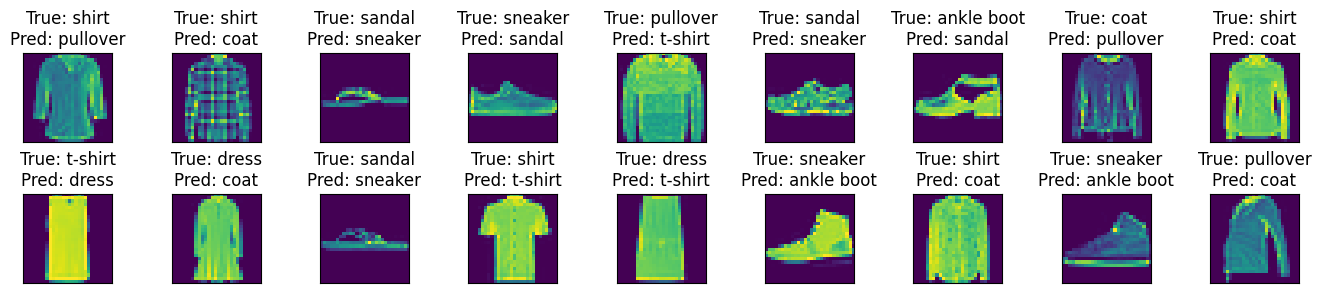

In [16]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Function to get text labels
def get_text_labels(indices):
    return [text_labels[int(i)] for i in indices]

wrong = preds.type(y.dtype) != y
X_wrong, y_wrong, preds_wrong = X[wrong], y[wrong], preds[wrong]

labels = [f'True: {true_label}\nPred: {pred_label}'
          for true_label, pred_label in zip(get_text_labels(y_wrong), get_text_labels(preds_wrong))]

# Visualization (using matplotlib)
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.squeeze(0).numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()


show_images(X_wrong, 2, 9, titles=labels)